# Standings Test
First we establish a valid oauth token below:

In [2]:
from yahoo_oauth import OAuth2
oauth = OAuth2(None, None, from_file='../oauth2.json')

[2019-09-10 10:00:10,574 DEBUG] [yahoo_oauth.yahoo_oauth.__init__] Checking 
[2019-09-10 10:00:10,578 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] ELAPSED TIME : 3097.5957465171814
[2019-09-10 10:00:10,581 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] TOKEN IS STILL VALID


This will run more frequently - this will check if the token is valid, if not, refresh. Then, we can try to download info from yahoo.

[2019-09-10 10:01:19,950 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] ELAPSED TIME : 3166.9671535491943
[2019-09-10 10:01:19,952 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] TOKEN IS STILL VALID


,Team Names,Actual,Projected,Wins,Losses,Ties
1,Matthew Masison,173.42,121.16,1,0,0
2,Action Macklin,164.32,124.00,1,0,0
3,I Eat Mop,150.52,121.29,1,0,0
4,Mike's Team,148.80,124.03,1,0,0
5,Bobby's Team,146.26,121.15,1,0,0
6,Six Sigmas,132.82,128.36,1,0,0
7,Diehydrogen Monoxyde,129.84,125.73,1,0,0
8,The Butt Fumblers,126.30,126.87,1,0,0
9,Sherlock Mahomes,122.70,117.58,1,0,0
10,Summer's Team,117.04,124.95,1,0,0


,Actual,Projected,Wins,Losses,Ties
Actual,1.000000,0.040487,0.559980,-0.559980,NaN
Projected,0.040487,1.000000,0.284973,-0.284973,NaN
Wins,0.559980,0.284973,1.000000,-1.000000,NaN
Losses,-0.559980,-0.284973,-1.000000,1.000000,NaN
Ties,NaN,NaN,NaN,NaN,NaN


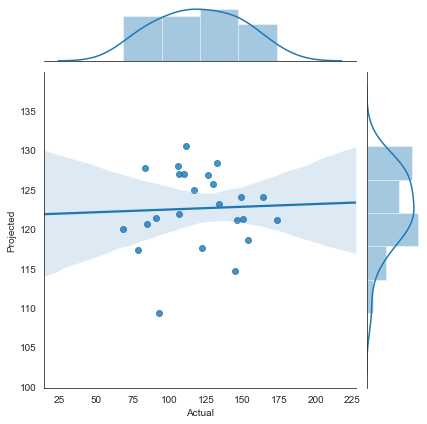

In [6]:
from bs4 import BeautifulSoup
import xml.etree.ElementTree as et 
import pandas as pd 

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set_style("white")


if not oauth.token_is_valid():
    oauth.refresh_access_token()
    
df_cols = ["projected points"]
out_df = pd.DataFrame(columns = df_cols)

num_teams = 8

league_ids = [1118202, 1110495, 1112355]

team_name_list = []
dist_series = pd.Series()
series_total = pd.Series()
series_wins = pd.Series()
series_losses = pd.Series()
series_ties = pd.Series()

for league_id in league_ids:
    url = "https://fantasysports.yahooapis.com/fantasy/v2/league/nfl.l."+str(league_id)+"/scoreboard;week=1"
    # url = "https://fantasysports.yahooapis.com/fantasy/v2/league/nfl.l.1118202/standings"
    # probably migrate to scoreboard when there is data... but unsure
    # url = "https://fantasysports.yahooapis.com/fantasy/v2/league/nfl.l.854917/scoreboard"
    # https://fantasysports.yahooapis.com/fantasy/v2/team/223.l.431.t.1/matchups;weeks=1,5
    payload = ""
    response = oauth.session.get(url, params=payload)

    # we only want to process data if there's data to pass.
    if not response.status_code == 200:
        print("Status Code Not Valid")
        print(response.text)
    else:

    #   XML Samples which are searchable can be found here: https://developer.yahoo.com/fantasysports/guide/

        soup = BeautifulSoup(response.text, 'lxml')
    #     Remove new line formatting from html to prevent confusion
        clean = str(soup).replace('\n', '')
    #     print(clean)
    #     print(soup.prettify())

    #  Get team Names:
    #     select all name tags beneath team tags
        s_team_names = soup.select('team_projected_points total')
    #     extract the text from the entire tag
        s_team_names = list(map(lambda x: float(x.text), s_team_names))
#         print(s_team_names)
    #     place that in a fancy little pandas series
        dist_series = dist_series.append(pd.Series(s_team_names), ignore_index=True)
#         print(dist_series)
        
        s_total = soup.select('team_points total')
        s_total = list(map(lambda x: float(x.text), s_total))
        series_total = series_total.append(pd.Series(s_total), ignore_index=True)
        
        tn_l = soup.select('team name')
        tn_l = list(map(lambda x: x.text, tn_l))
        team_name_list+=tn_l
    url = "https://fantasysports.yahooapis.com/fantasy/v2/league/nfl.l."+ str(league_id) +"/standings"
    response = oauth.session.get(url)
    if not response.status_code == 200:
        print("Status Code 2nd request Not Valid")
        print(response.text)
    else:
        soup = BeautifulSoup(response.text, 'lxml')
#         print(soup.prettify())
        s_wl_index = soup.select('team name')
        s_wl_index = list(map(lambda x: x.text, s_wl_index))
#         wl_index.append(s_wl_index)
    
        s_wins = soup.select('wins')
        s_wins = list(map(lambda x: int(x.text), s_wins))
        series_wins = series_wins.append(pd.Series(s_wins, index=s_wl_index))
        
        s_losses = soup.select('losses')
        s_losses = list(map(lambda x: int(x.text), s_losses))
        series_losses = series_losses.append(pd.Series(s_losses, index=s_wl_index))
        
        s_ties = soup.select('ties')
        s_ties = list(map(lambda x: int(x.text), s_ties))
        series_ties = series_ties.append(pd.Series(s_ties, index=s_wl_index))

data = {"Actual": series_total, "Projected": dist_series, "Team Names": team_name_list}
final_df = pd.DataFrame(data).set_index("Team Names")

# The order is different int this call (by standing), so index must be assigned in the series then matched up with the final df

final_df['Wins'] = series_wins
final_df['Losses'] = series_losses
final_df['Ties'] = series_ties

final_df = final_df.sort_values(by=['Wins',"Actual"], ascending=[False,False])
final_df = final_df.reset_index()
final_df.index +=1

display(final_df)
# sns.boxplot(data=final_df, order=["Projected", "Actual"])
# sns.kdeplot(final_df.projected, final_df.actual)
# sns.distplot(dist_series, bins=12);
sns.jointplot(data=final_df, y="Projected", x="Actual", kind="reg", label="Team Names")
final_df.corr(method="pearson")
